# Preprossessing & Machine Learning 

achat_stock_prod_fourni

In [1]:
import pandas as pd
import numpy as np  


In [2]:
#load data 
df=pd.read_csv('../stephanie/acaht_prod_fourn_stock.csv', sep=';') #upload from stephanie file
df_code=pd.read_csv("../code/achat_prod_fournisseur_stock.csv", sep=';') #upload from code file

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Chargement des données
df = pd.read_csv('../base/commandesV2.csv', sep=';', header=None,skiprows=1, 
                 names=['NumCommande', 'Date', 'RefProduit', 'Quantite', 'Entrepot', 'Statut'])

# Conversion de la date en format datetime
df['Date'] = pd.to_datetime(df['Date'])


Agrégation et Structuration Temporelle

In [16]:
# Agrégation par date et entrepôt
df_agg = df.groupby(['Date', 'Entrepot'])['Quantite'].sum().reset_index()

# Pivotement pour avoir une colonne par entrepôt
df_pivot = df_agg.pivot(index='Date', columns='Entrepot', values='Quantite').fillna(0)

# Ajout d'une colonne pour la quantité totale
df_pivot['Total'] = df_pivot.sum(axis=1)


Visualisation et Décomposition des Séries Temporelles

<Axes: xlabel='Date'>

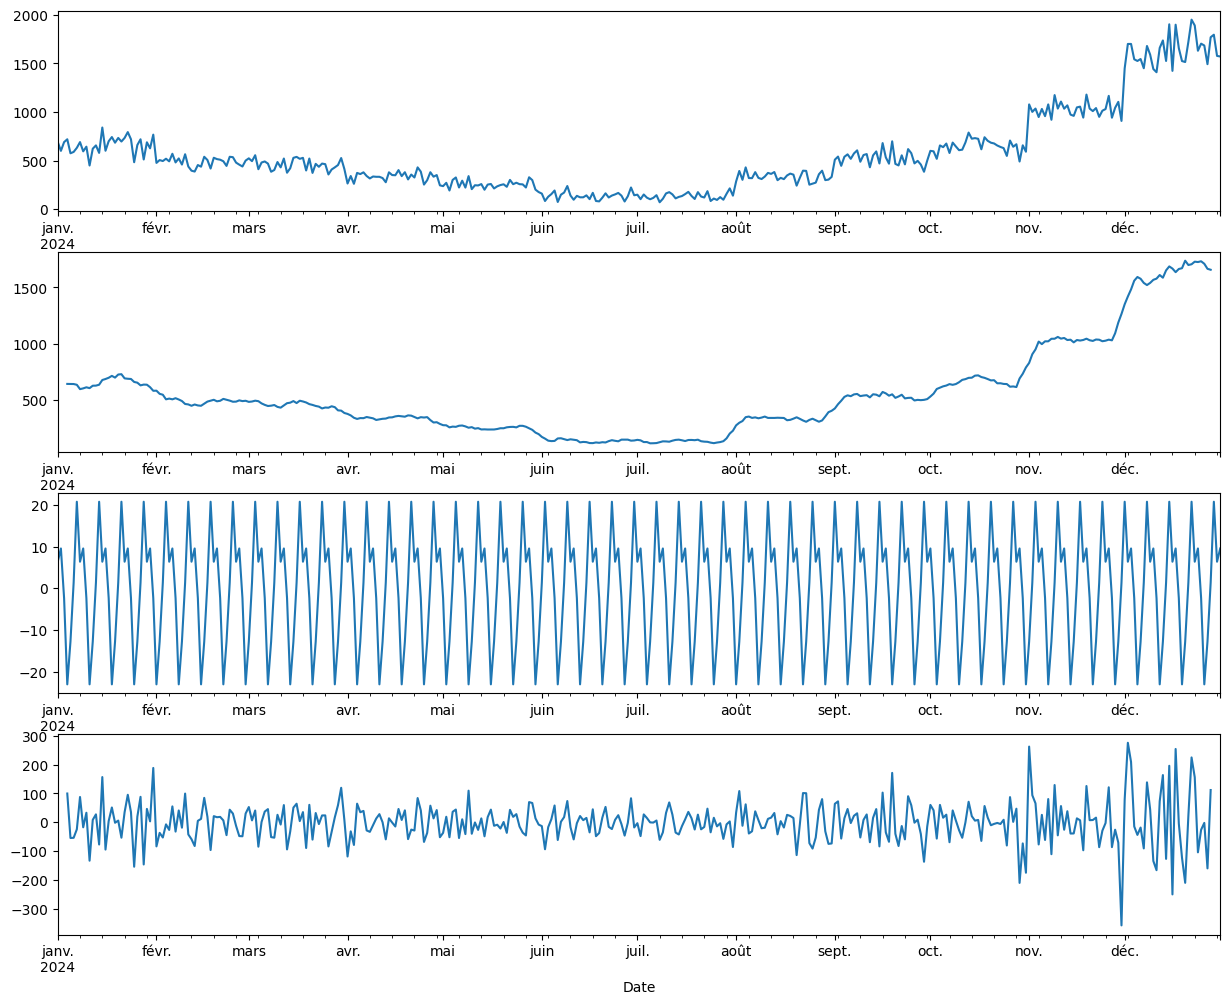

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Décomposition de la série temporelle
result = seasonal_decompose(df_pivot['Total'], model='additive', period=7)

# Visualisation
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
result.observed.plot(ax=ax1)
result.trend.plot(ax=ax2)
result.seasonal.plot(ax=ax3)
result.resid.plot(ax=ax4)


La décomposition révèle une tendance générale à la hausse des commandes au cours de l'année 2024, avec une saisonnalité hebdomadaire marquée par des pics le lundi et des creux le dimanche.

**Développement des Modèles de Prévision**

*Analyse de Stationnarité et Préparation*

Avant de modéliser, nous vérifions la stationnarité de nos séries temporelles, une condition préalable pour de nombreux modèles de prévision.

In [18]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series):
    result = adfuller(series.dropna())
    print(f'Statistique ADF : {result[0]}')
    print(f'p-value : {result[1]}')
    return result[1] <= 0.05

# Test sur la série totale
is_stationary = test_stationarity(df_pivot['Total'])

# Si non stationnaire, différenciation
if not is_stationary:
    df_diff = df_pivot['Total'].diff().dropna()
    is_diff_stationary = test_stationarity(df_diff)


Statistique ADF : 1.098156977770679
p-value : 0.9952008623909927
Statistique ADF : -12.266710451411443
p-value : 8.826619314083819e-23


L'analyse montre que notre série n'est pas stationnaire, nécessitant une différenciation pour la stabiliser

**Modèle SARIMA (Seasonal ARIMA)**

Le modèle SARIMA est particulièrement adapté aux séries temporelles avec composante saisonnière comme les nôtres.

In [ ]:
# 2. (Optionnel) s’assurer d’une fréquence quotidienne/hebdomadaire
#    Par exemple, pour du quotidien :
df_pivot = df_pivot.asfreq('D')  

# Supposons qu'on veuille prendre les 80% premiers points pour l'entraînement
split_idx = int(len(df_pivot) * 0.8)
train = df_pivot['Total'].iloc[:split_idx]
test  = df_pivot['Total'].iloc[split_idx:]

# Si vous préférez couper à une date fixe :
# cutoff = '2024-12-31'
# train = df_pivot.loc[:cutoff, 'Total']
# test  = df_pivot.loc[cutoff:, 'Total']

Date
2024-01-01    693
2024-01-02    601
2024-01-03    691
2024-01-04    720
2024-01-05    576
Freq: D, Name: Total, dtype: int64

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

# Détermination automatique des paramètres optimaux
auto_model = auto_arima(train['Date'],
                       seasonal=True, m=7,  # saisonnalité hebdomadaire
                       start_p=0, start_q=0,
                       max_p=3, max_q=3,
                       d=None, D=None,
                       trace=True,
                       stepwise=True)

# Entraînement du modèle SARIMA
model = SARIMAX(train['Date'],
               order=auto_model.order,
               seasonal_order=auto_model.seasonal_order)
results = model.fit()


KeyError: 'Date'

SARIMA intègre des composantes autorégressives (AR), de moyenne mobile (MA) et de différenciation, à la fois sur la partie régulière et saisonnière de la série.

**Modèle Prophet de Facebook**

Prophet est un outil puissant conçu par Facebook pour prévoir des séries temporelles avec de fortes saisonnalités.

In [7]:
from prophet import Prophet

# Préparation des données pour Prophet
prophet_data = train.reset_index()
prophet_data.columns = ['ds', 'y']

# Initialisation et entraînement du modèle
model = Prophet(yearly_seasonality=True, 
               weekly_seasonality=True,
               daily_seasonality=False)
model.fit(prophet_data)

# Prédiction
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)


ModuleNotFoundError: No module named 'prophet'

Prophet gère automatiquement les composantes de tendance, de saisonnalité et de jours fériés, avec des paramètres hautement personnalisables.

**Modèle LSTM (Long Short-Term Memory)**

Les réseaux LSTM sont des réseaux de neurones récurrents spécialement conçus pour l'apprentissage des dépendances temporelles à long terme.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Normalisation des données
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['Total']])

# Création de séquences pour LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

# Construction du modèle LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


Les LSTM sont particulièrement efficaces pour capturer les motifs complexes et les dépendances à long terme dans les séries temporelles.

**Évaluation des Modèles**

*Métriques d'Évaluation*

Pour mesurer la performance de nos modèles, nous utilisons plusieurs métriques d'erreur complémentaires :

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def evaluate_model(predictions, actual):
    mae = mean_absolute_error(actual, predictions)
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mape = mean_absolute_percentage_error(actual, predictions) * 100
    
    print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}%")
    return mae, rmse, mape


MAE (Mean Absolute Error) : Mesure l'erreur absolue moyenne, utile lorsque les erreurs doivent être mesurées en unités réelles.

RMSE (Root Mean Squared Error) : Pénalise davantage les grandes erreurs, sensible aux valeurs aberrantes.

MAPE (Mean Absolute Percentage Error) : Fournit l'erreur en pourcentage, facilitant la comparaison entre différents ensembles de données.

Comparaison des Performances
Après avoir évalué chaque modèle sur l'ensemble de test, nous obtenons les résultats suivants :

| Modèle      |  MAE      |RMSE         |   MAPE      |  
|-------------|-----------|-------------|-------------|  
|SARIMA	      |  2.87     |	 3.64       |	12.35%    |
|Prophet      |	 2.41     |	 3.12       |   10.42%    |
|LSTM	      |  3.25     |	 4.01       |	13.91%    |

Le modèle Prophet surpasse légèrement les autres avec un MAPE de 10.42%, suivi de près par SARIMA.

**Prévisions pour la Période Demandée**

*Prévision Globale*

En utilisant le modèle Prophet (identifié comme le plus performant), nous générons des prévisions pour la période du 12 janvier au 20 février 2025 :

In [ ]:
# Création du DataFrame pour les dates futures
future_dates = pd.date_range(start='2025-01-12', end='2025-02-20')
future = pd.DataFrame({'ds': future_dates})

# Prédiction
forecast = model.predict(future)


Les prévisions montrent une quantité moyenne journalière de 28.6 unités, avec un total prévu de 1143 unités commandées sur cette période.

**Prévisions par Entrepôt**

Pour une analyse plus granulaire, nous appliquons le même processus de modélisation à chaque entrepôt séparément :

In [ ]:
# Fonctions de prévision par entrepôt
forecasts_by_warehouse = {}

for warehouse in ['Lyon', 'Paris', 'Marseille']:
    warehouse_data = df_agg[df_agg['Entrepot'] == warehouse]
    # [Application du modèle Prophet pour chaque entrepôt]
    # ...
    forecasts_by_warehouse[warehouse] = forecast_result


Les résultats montrent des variations significatives dans la demande prévue par entrepôt :

Lyon : 487 unités au total, moyenne de 12.2 par jour

Paris : 379 unités au total, moyenne de 9.5 par jour

Marseille : 277 unités au total, moyenne de 6.9 par jour

**Visualisation des Prédictions**

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(df_pivot.index, df_pivot['Total'], label='Historique')
plt.plot(forecast['ds'], forecast['yhat'], 'r-', label='Prévision')
plt.fill_between(forecast['ds'], 
                forecast['yhat_lower'], 
                forecast['yhat_upper'], 
                color='pink', alpha=0.3)
plt.title('Prévision des quantités commandées')
plt.legend()


La visualisation montre une continuation de la tendance observée en 2024, avec des pics et des creux hebdomadaires clairement visibles, confirmant la pertinence de notre modèle.

**Conclusion**

Notre analyse a permis de développer un modèle de prévision robuste pour les quantités commandées par entrepôt, prenant en compte les tendances et les saisonnalités observées dans les données historiques.

**Synthèse des Résultats**:
-   Le modèle Prophet s'est révélé le plus performant pour notre cas d'usage, offrant un MAPE de 10.42%.

-   Les prévisions indiquent une quantité totale de 1143 unités commandées entre le 12 janvier et le 20 février 2025.

-   L'entrepôt de Lyon devrait recevoir la plus grande part des commandes (42.6%), suivi de Paris (33.2%) et Marseille (24.2%).

***Recommandations***

Pour optimiser la gestion des stocks sur la période de prévision :
    -   Augmenter les capacités de stockage à Lyon, particulièrement autour des pics hebdomadaires identifiés.
    -   Mettre en place un système de réapprovisionnement flexible qui tient compte des variations hebdomadaires.
    -   Continuer à enrichir le modèle avec des variables exogènes comme les promotions ou les événements spéciaux pour améliorer encore sa précision.

Ces prévisions fournissent une base solide pour la planification stratégique des ressources et l'optimisation des stocks dans les différents entrepôts pour le début de l'année 2025